In [1]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')

# Load Fitness (SA609) Data

In [174]:
adata = sc.read("fitness.h5ad")
dataset = GeneVectorDataset(adata)
embed = GeneEmbedding("fitness.vec", dataset,vector="average")
print(embed.compute_similarities("ID1").head(20))

Loading Expression.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9479931/9479931 [01:26<00:00, 109233.71it/s]


Reindexing Cooc


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19799/19799 [00:01<00:00, 10795.66it/s]


Loading average of 1st and 2nd weights.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3968121.10it/s]

        Gene  Similarity
0        ID1    1.000000
1        ID3    0.985936
2        ID4    0.905840
3        ID2    0.867575
4       HES1    0.812745
5      STAT3    0.689662
6      NPAS4    0.641094
7      KCNH8    0.587062
8       MSX2    0.584242
9      ARL4C    0.561706
10     SNAI2    0.534862
11     DHRS2    0.480326
12     SOCS3    0.479929
13      HES4    0.473998
14      JUNB    0.470213
15  FAM189A2    0.442470
16    TIPARP    0.433232
17     ZFP36    0.426985
18      SOX9    0.424349
19     THBS1    0.421060


In [162]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19799/19799 [00:43<00:00, 452.83it/s]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


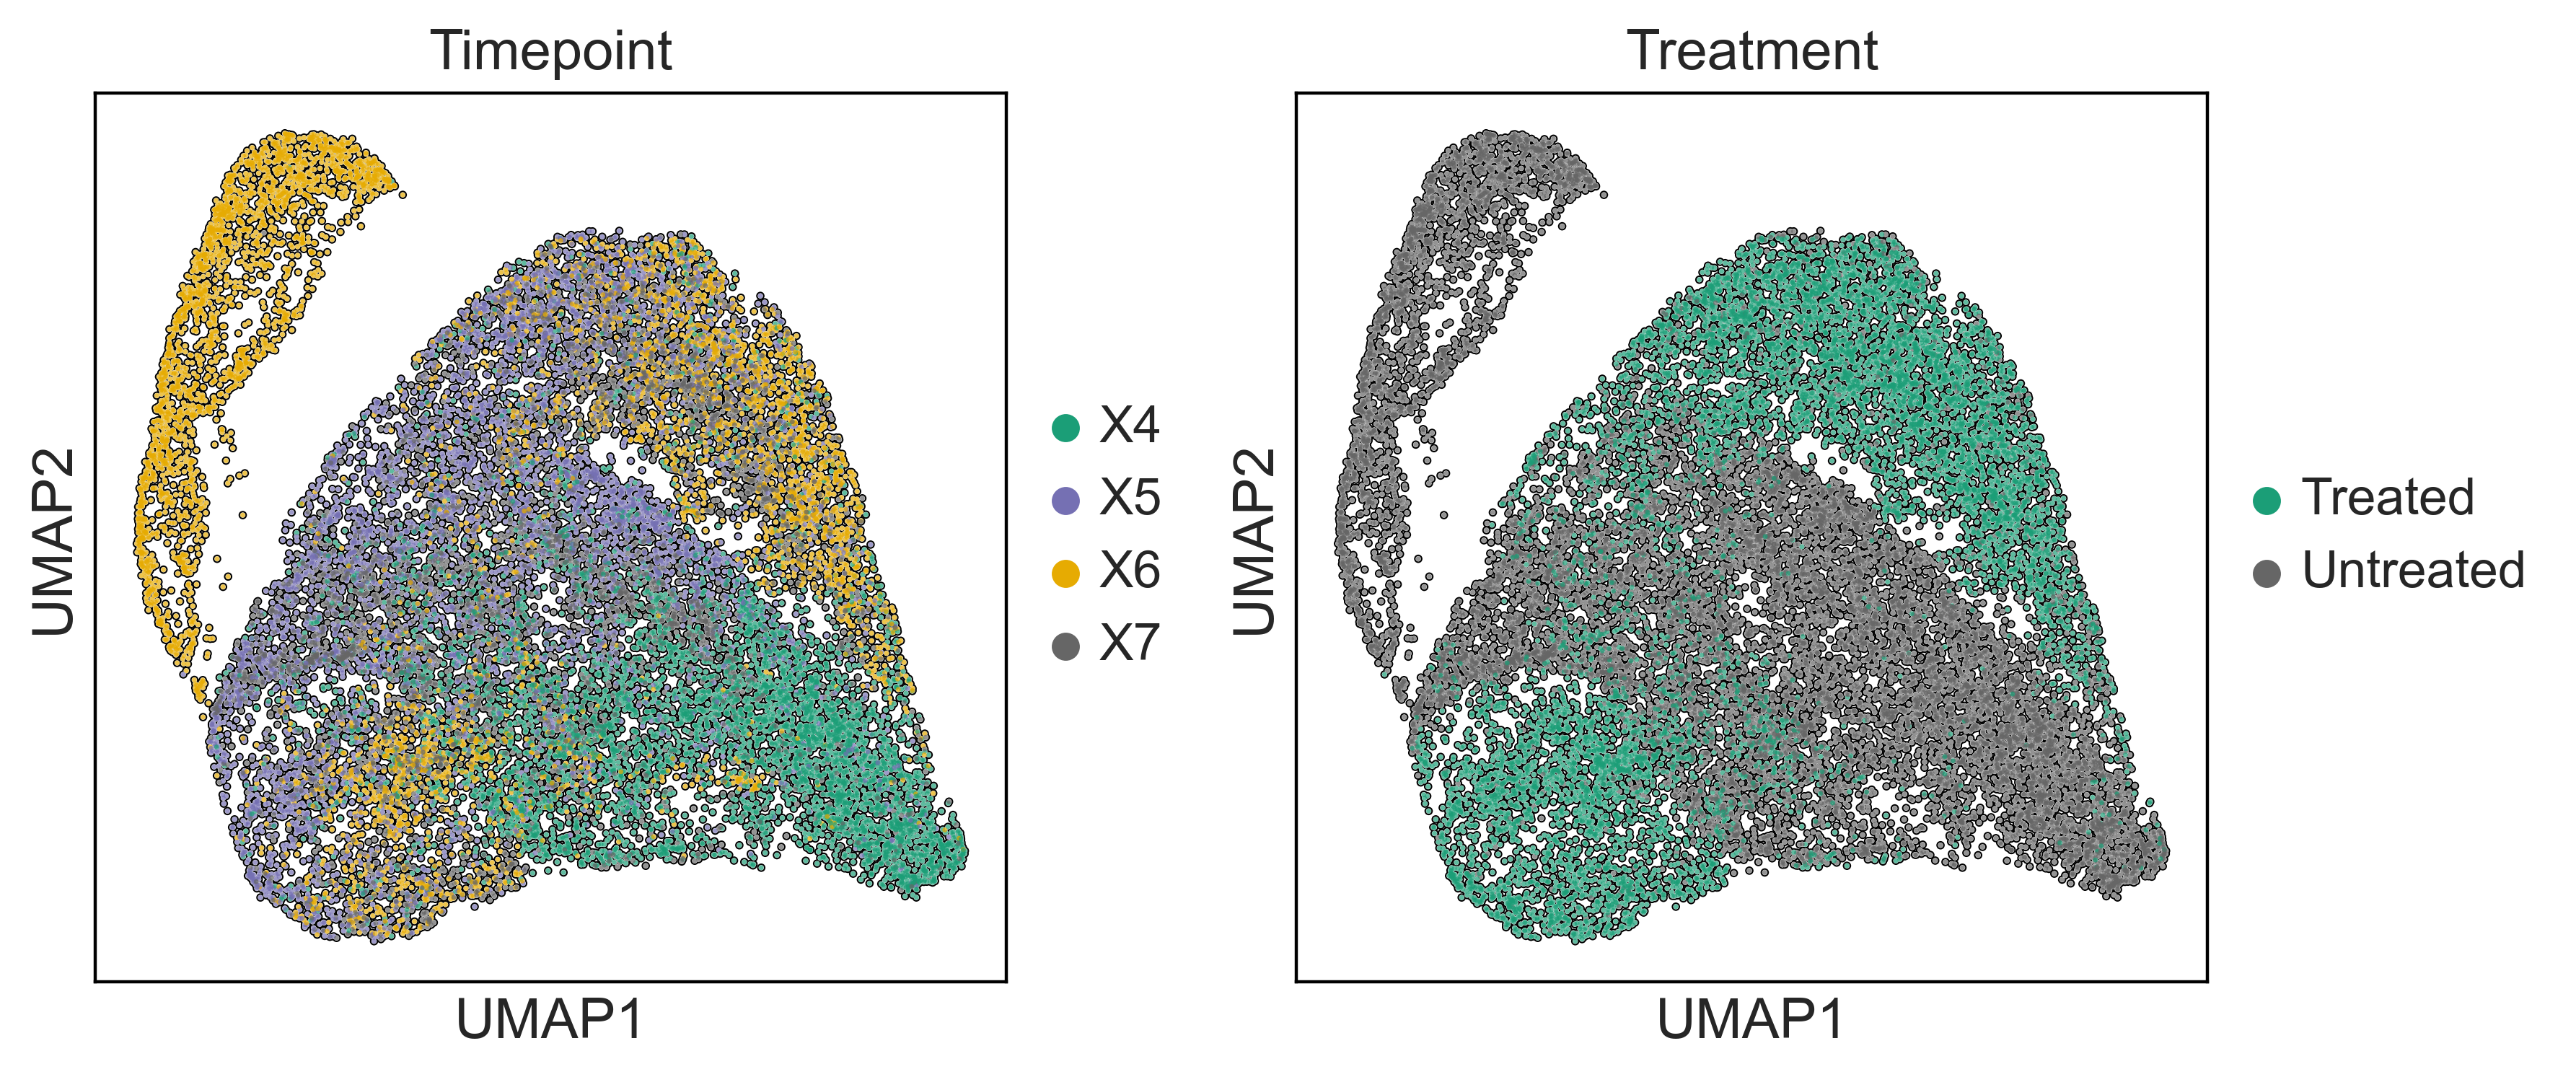

In [163]:
sc.pl.umap(adata, color=["timepoint","treatment"],palette="Dark2",
           wspace=0.2,title=["Timepoint","Treatment"], add_outline=True)

# Generate Metagenes and Look at Genes Similar to ID1 in Gene Embedding (cosine distance)

In [164]:
gdata = embed.get_adata(resolution=30)
metagenes = embed.get_metagenes(gdata)
embed.compute_similarities('ID1')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 234 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


Gene  Similarity
0           ID1    1.000000
1           ID3    0.985936
2           ID4    0.905840
3           ID2    0.867575
4          HES1    0.812745
...         ...         ...
1995     DCDC2C   -0.021510
1996      MMP10   -0.023314
1997       CST2   -0.025659
1998      TECTB   -0.030239
1999  LINC01222   -0.031658

[2000 rows x 2 columns]

# Gene Module Scoring

In [175]:
%%capture
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
embed.score_metagenes(adata, metagenes)

# Run OLS over Treated Timepoints for Scoring for Each Metagene

In [166]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tqdm
import numpy
import pandas

t = adata[adata.obs["treatment"]=="Treated"]

t_slope = dict()
t_pvalues = dict()
clusters = []
order = ['UT', 'UTT', 'UTTT', 'UTTTT']
tps = [0,1,2,3]

for cluster, vector in metagenes.items():
    cluster = cluster + "_SCORE"
    values = []
    conditions = []
    ts = []
    for condition,tp in zip(order,tps):
        sub = t[t.obs["condition"]==condition]
        val = sub.obs[cluster].tolist()
        values += val
        ts += [tp for _ in val]
    df = pandas.DataFrame.from_dict({"condition":ts,"expression":values})    
    res = ols("expression ~ C(condition)", data=df).fit()
    t_pvalues[cluster] = res.summary2().tables[1]['P>|t|']["C(condition)[T.1]"]
    t_slope[cluster] = res.params['C(condition)[T.1]']

# Run again over Untreated Timepoints

In [167]:
u = adata[adata.obs["treatment"]=="Untreated"]

u_slope = dict()
u_pvalues = dict()
clusters = []
order = ['UU', 'UUU', 'UUUU', 'UUUUU']
tps = [0,1,2,3]

for cluster, vector in metagenes.items():
    cluster = cluster + "_SCORE"
    values = []
    conditions = []
    ts = []
    for condition,tp in zip(order,tps):
        sub = u[u.obs["condition"]==condition]
        val = sub.obs[cluster].tolist()
        values += val
        ts += [tp for _ in val]
    df = pandas.DataFrame.from_dict({"condition":ts,"expression":values})    
    res = ols("expression ~ C(condition)", data=df).fit()
    u_pvalues[cluster] = res.summary2().tables[1]['P>|t|']["C(condition)[T.1]"]
    u_slope[cluster] = res.params['C(condition)[T.1]']

# Load P-values and Coefficients in Data Frame

In [168]:
u_s = []
t_s = []
u_p = []
t_p = []
mgs = []
classt = []
for cluster in metagenes.keys():
    cluster = cluster + "_SCORE"
    t_s.append(t_slope[cluster])
    u_s.append(u_slope[cluster])
    u_p.append(t_pvalues[cluster])
    t_p.append(t_pvalues[cluster])
    mgs.append(cluster)
df = pandas.DataFrame.from_dict({"Metagene":mgs,
                                 "Untreated Coeff":u_s,
                                 "Treated Coeff":t_s,
                                 "Untreated pval":u_p,
                                 "Treated pval":t_p})

# Subset MGs that Increase in Treated with Significant Pvalue (Examine Untreated Coeff)

In [169]:
dfx = df[df["Treated pval"] < 0.001]
dfx = dfx[dfx["Treated Coeff"] > 0.1]
dfx = dfx.sort_values("Treated Coeff",ascending=False).head(5)
dfx

Metagene  Untreated Coeff  Treated Coeff  Untreated pval   Treated pval
100    3_SCORE        -0.005506       0.170703   1.981849e-202  1.981849e-202
68   114_SCORE         0.005637       0.157581   1.283771e-157  1.283771e-157
27   163_SCORE        -0.010180       0.117798    3.334341e-75   3.334341e-75
74   120_SCORE         0.007657       0.114169    2.249983e-60   2.249983e-60
108  141_SCORE         0.007917       0.112862    5.002041e-97   5.002041e-97

# Look at only top 5 most increasing - Run GSEA with Hallmark Geneset

In [170]:
import gseapy as gp
import collections
enrc = collections.defaultdict(dict)
terms = set()
mgs = []
for mg in dfx["Metagene"]:
    print(mg, metagenes[mg.replace("_SCORE","")])
    enr = gp.enrichr(gene_list=metagenes[mg.replace("_SCORE","")],
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human', 
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     cutoff=0.001 
                    )    
    mgs.append(mg)
    for x,y in zip(enr.res2d["Term"],enr.res2d["Combined Score"]):
        enrc[mg][x] = y
        terms.add(x)

3_SCORE ['BARX1', 'CRABP2', 'DMKN', 'EPCAM', 'FOXP1', 'GAGE13', 'GAGE2A', 'KRTCAP3', 'LSR', 'MAP7D2', 'NPW', 'SAP25', 'SFRP1', 'SPINT2', 'SYCP2', 'TCF4', 'TDRD12', 'TSHZ2', 'ZFHX3']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-07-24 23:44:50,271 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


114_SCORE ['ARF5', 'EGFL6', 'MAEL', 'MEST', 'PITX1', 'TUBB2A', 'VCX', 'VCX3B']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-07-24 23:44:52,606 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


163_SCORE ['AFF3', 'BOC', 'CCDC14', 'LSAMP', 'STEAP1', 'TSPAN13']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-07-24 23:44:54,861 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


120_SCORE ['ARID5B', 'ETV5', 'FZD1', 'RASL11B', 'RBP1', 'SIX2', 'TESC', 'TMEM178A']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-07-24 23:44:56,767 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


141_SCORE ['BTG2', 'ID1', 'ID2', 'ID3', 'ID4', 'JUNB', 'STAT3']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [171]:
mat = []
for term in terms:
    row = []
    for mg in mgs:
        if term in enrc[mg]:
            row.append(enrc[mg][term])
        else:
            row.append(0.0)
    mat.append(row)

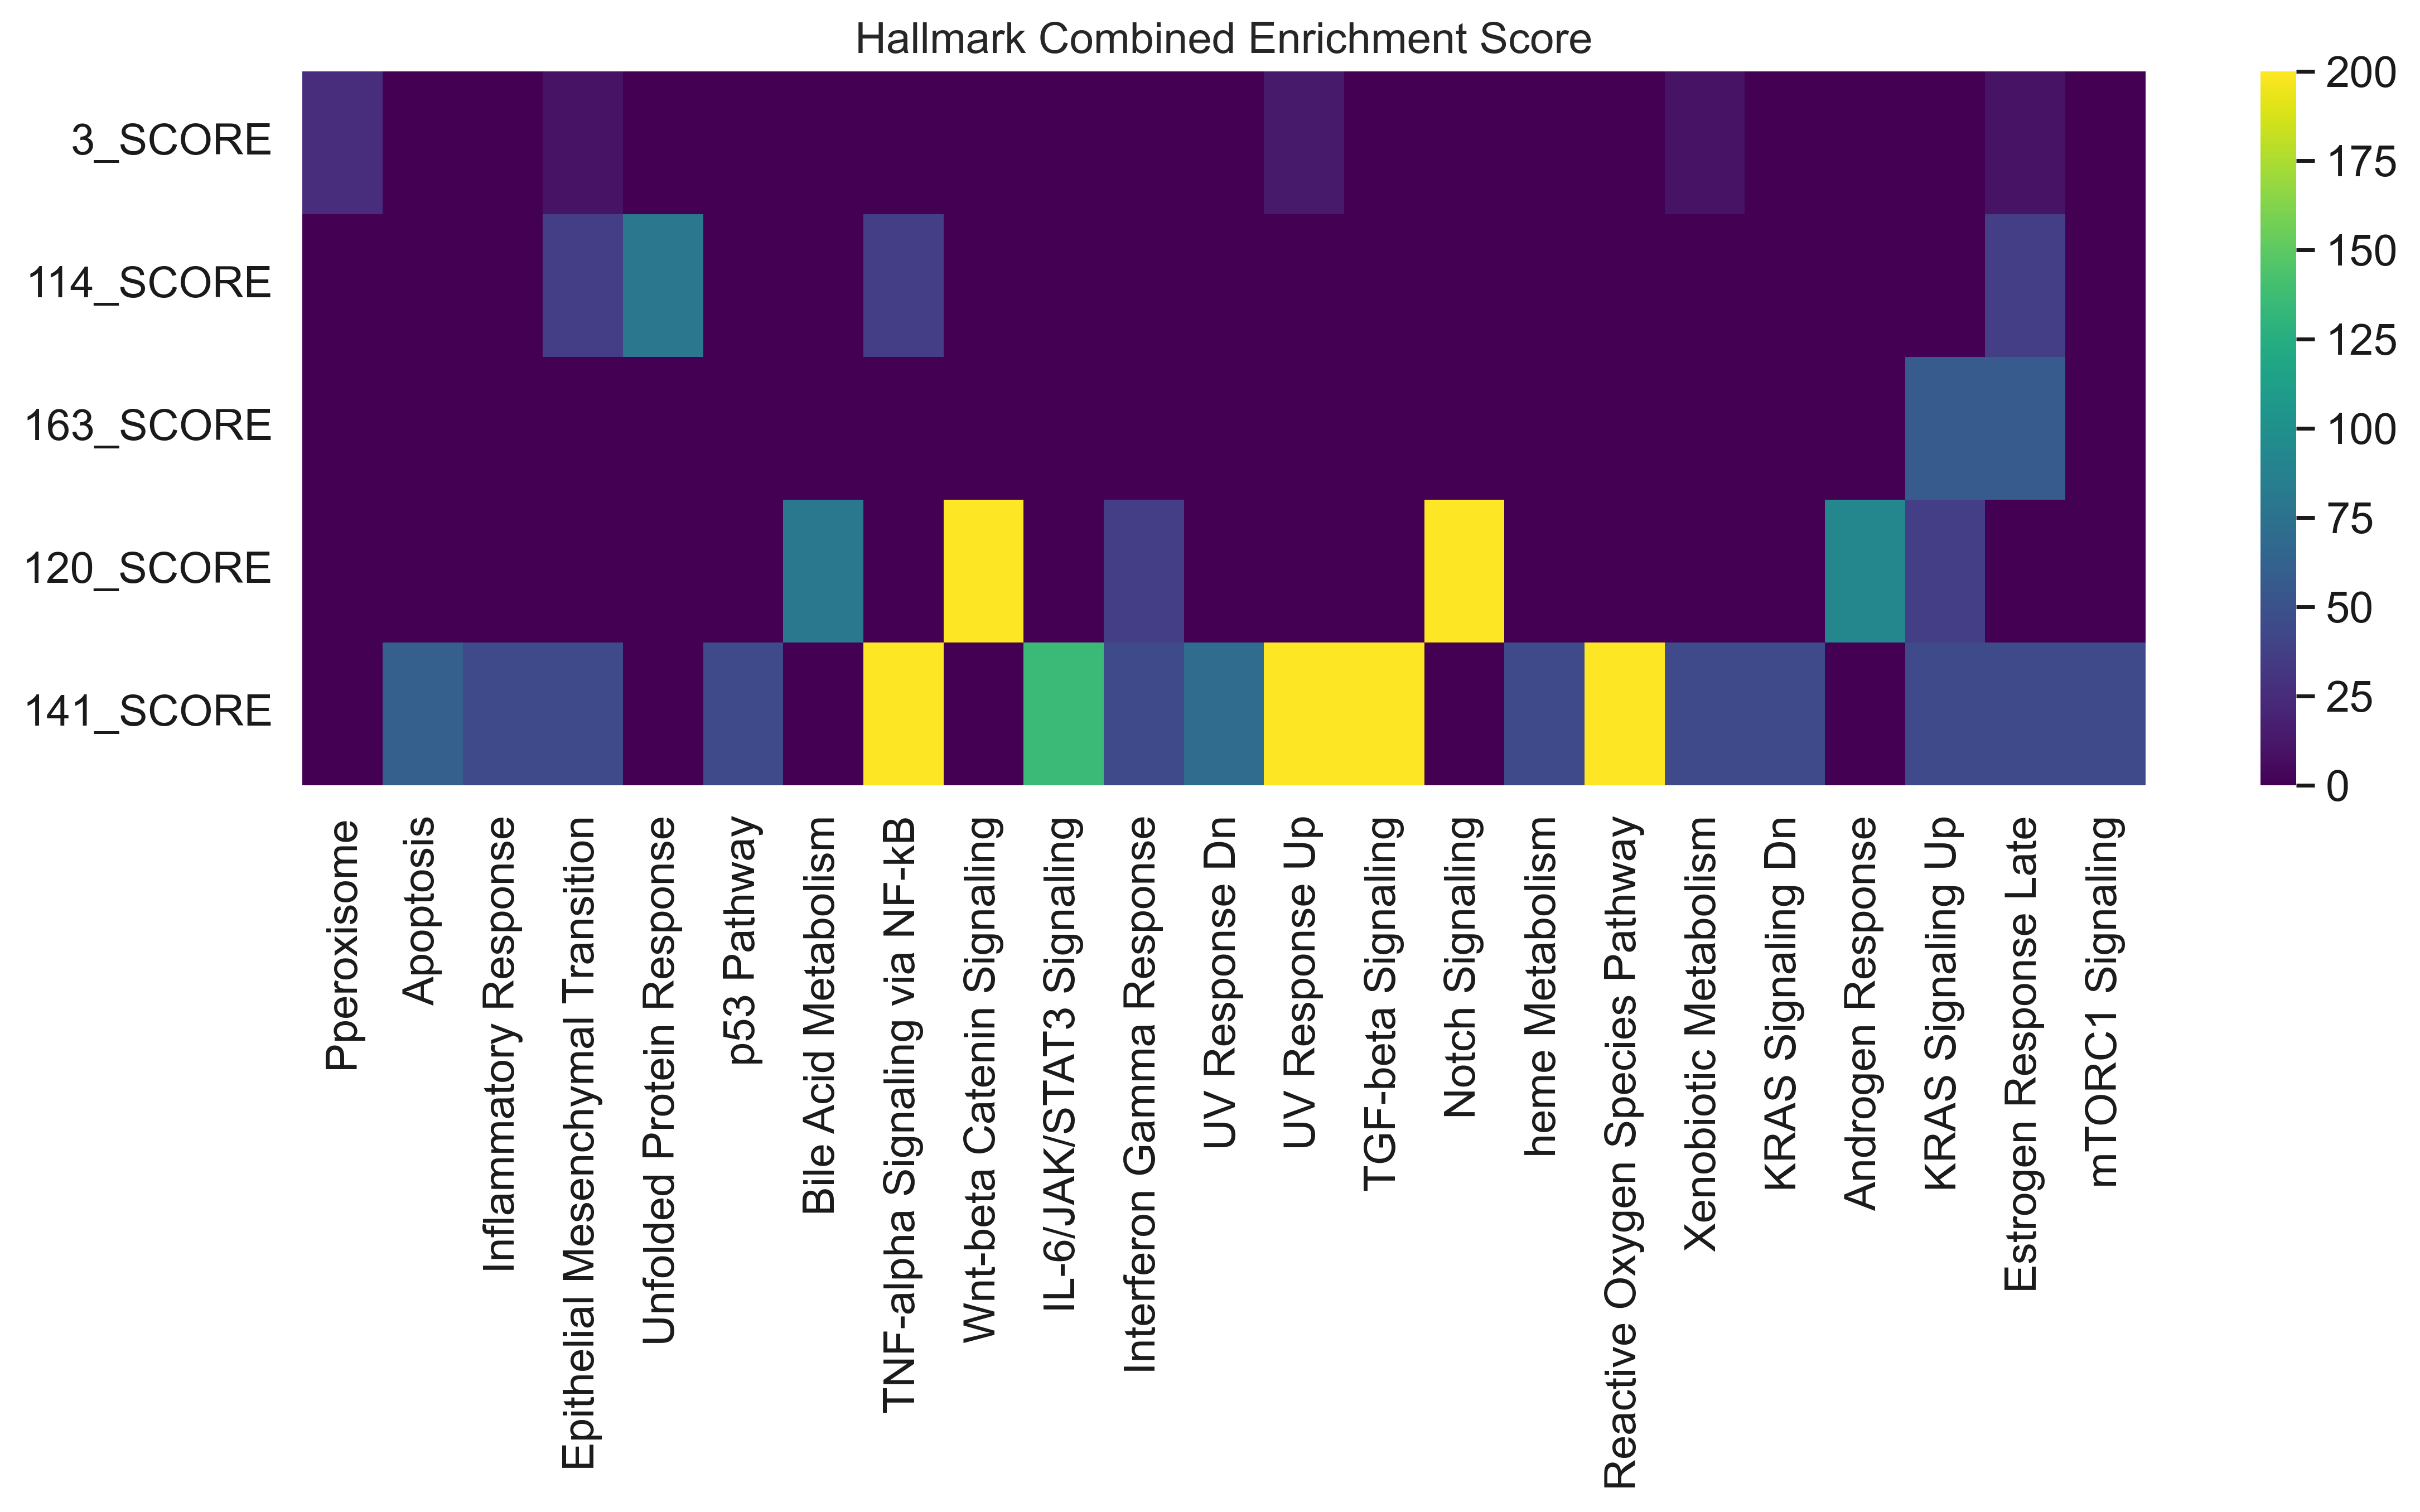

In [172]:
df = pandas.DataFrame(numpy.array(mat),columns=mgs,index=terms).T
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.heatmap(df,yticklabels=True,xticklabels=True,ax=ax, vmax=200,cmap="viridis")
ax.set_title("Hallmark Combined Enrichment Score")
fig.tight_layout()

# Most interesting Metagene 141

In [177]:
metagenes["141"]

['BTG2', 'ID1', 'ID2', 'ID3', 'ID4', 'JUNB', 'STAT3']